# Covid-19 infección en Ecuador. Modelos matemáticos y predicciones
Una comparación de modelos, lineal, polilnomico,logísticos y exponenciales aplicados a la infección por el virus Covid-19

Se realiza un análisis matemático simple del crecimiento de la infección en Python y dos modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de curva.

In [2]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# Actualizar los datos (URL)
url = 'http://cowid.netlify.com/data/full_data.csv'

df = pd.read_csv(url)
df

date             object
location         object
new_cases       float64
new_deaths      float64
total_cases       int64
total_deaths    float64
dtype: object


date     location  new_cases  new_deaths  total_cases  \
0     2020-02-25  Afghanistan        NaN         NaN            1   
1     2020-02-26  Afghanistan        0.0         NaN            1   
2     2020-02-27  Afghanistan        0.0         NaN            1   
3     2020-02-28  Afghanistan        0.0         NaN            1   
4     2020-02-29  Afghanistan        0.0         NaN            1   
...          ...          ...        ...         ...          ...   
2862  2020-03-13        World     7488.0       338.0       132758   
2863  2020-03-14        World     9761.0       433.0       142534   
2864  2020-03-15        World    10967.0       343.0       153517   
2865  2020-03-16        World    13971.0       855.0       167506   
2866  2020-03-17        World    11594.0       819.0       179112   

      total_deaths  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
2862        4956.0  
2863        5392.0  
2864        5735.0  
2865        6606.0  
2866        7426.0  

[2867 rows x 6 columns]

Imprimos los resultados y agregamos el numero del dia


In [5]:
df = df[df['location'].isin(['Ecuador'])] #Filtro la Informacion solo para Ecuador
df = df.loc[:,['date','total_cases', 'new_cases']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df

date  total_cases
681    60            1
682    61            1
683    62            6
684    63            7
685    64            7
686    65           13
687    66           14
688    67           14
689    68           15
690    69           15
691    70           15
692    71           17
693    72           17
694    73           23
695    74           23
696    75           37
697    76           58

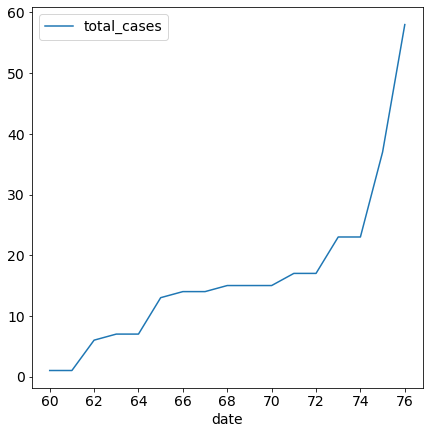

In [19]:
df.plot(x ='date', y='total_cases')

Ahora podemos analizar los cuatro modelos que tomaré en el examen, que son la función lineal, polinomica,logística y la función exponencial . Cada modelo tiene tres parámetros , que se estimarán mediante un cálculo de ajuste de curva en los datos históricos.

## EL modelo lineal

La regresión lineal es un algoritmo de aprendizaje supervisado que se utiliza en Machine Learning y en estadística. En su versión más sencilla, lo que haremos es «dibujar una recta» que nos indicará la tendencia de un conjunto de datos continuos.

Recordemos rápidamente la fórmula de la recta:

Y = mX + b

Donde Y es el resultado, X es la variable, m la pendiente (o coeficiente) de la recta y b la constante o también conocida como el «punto de corte con el eje Y» en la gráfica (cuando X=0)
Ejemplo
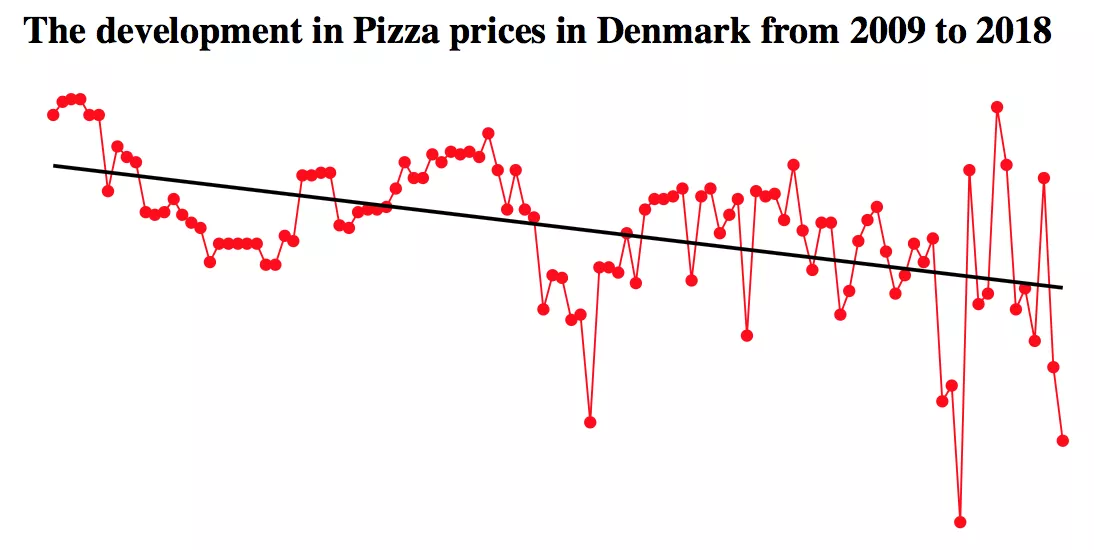

Recordemos que los algoritmos de Machine Learning Supervisados, aprenden por sí mismos y -en este caso- a obtener automáticamente esa «recta» que buscamos con la tendencia de predicción. Para hacerlo se mide el error con respecto a los puntos de entrada y el valor «Y» de salida real.



In [20]:
x = list(df.iloc [:, 0]) # Fecha
y = list(df.iloc [:, 1]) # Numero de casos
# Creamos el objeto de Regresión Lineal
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(np.array(x).reshape(-1, 1) ,y)

# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio

Coefficients: 
 [2.31617647]
Independent term: 
 -140.85294117647064


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [21]:
#Vamos a comprobar:
# Quiero predecir cuántos "Casos" voy a obtener por en el dia 100,
# según nuestro modelo, hacemos:
y_prediccion = regr.predict([[100]])
print(int(y_prediccion))

90


[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]


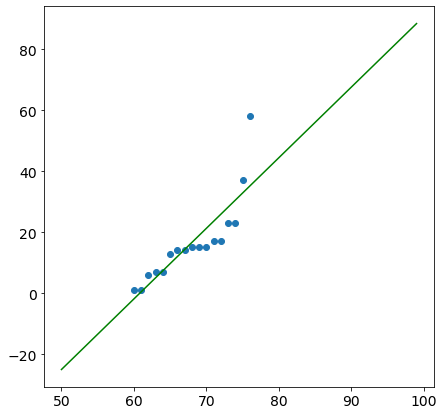

In [22]:
#Graficar
plt.scatter(x, y)
x_real = np.array(range(50, 100))
print(x_real)
plt.plot(x_real, regr.predict(x_real.reshape(-1, 1)), color='green')
plt.show()



## El modelo logistico

El modelo logístico se ha utilizado ampliamente para describir el crecimiento de una población. Una infección puede describirse como el crecimiento de la población de un agente patógeno, por lo que un modelo logístico parece razonable .
La expresión más genérica de una función logística es:

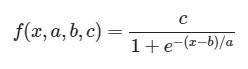

En esta fórmula, tenemos la variable x que es el tiempo y tres parámetros: a, b, c .

- a se refiere a la velocidad de infección
- b es el día en que ocurrieron las infecciones máximas
- c es el número total de personas infectadas registradas al final de la infección
 


A continuacion se puede apreciar un ejemplo de regresion logistica
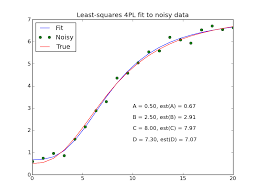

Definamos la función en Python y realicemos elprocedimiento de ajuste de curva utilizado para el crecimiento logístico.

In [23]:
def modelo_logistico(x,a,b):
    return a+b*np.log(x)

exp_fit = curve_fit(modelo_logistico,x,y) #Extraemos los valores de los paramatros
print(exp_fit)


(array([-637.69367899,  155.1710206 ]), array([[11872.54041469, -2814.63865054],
       [-2814.63865054,   667.4662425 ]]))


## Graficas

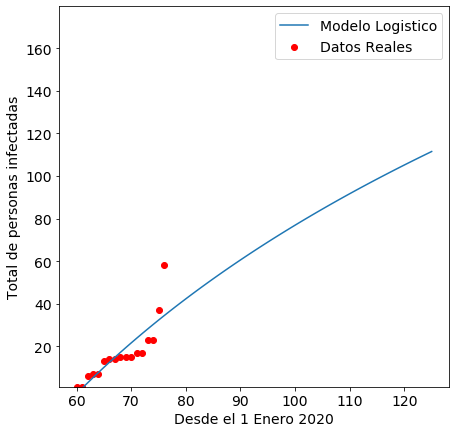

In [24]:
pred_x = list(range(min(x),max(x)+50)) # Predecir 50 dias mas
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Datos Reales",color="red")
# Predicted exponential curve
plt.plot(pred_x, [modelo_logistico(i,exp_fit[0][0],exp_fit[0][1]) for i in pred_x], label="Modelo Logistico" )
plt.legend()
plt.xlabel("Desde el 1 Enero 2020")
plt.ylabel("Total de personas infectadas")
plt.ylim((min(y)*0.9,max(y)*3.1)) # Definir los limites de Y
plt.show()

## Modelo exponencial

Mientras que el modelo logístico describe un crecimiento de infección que se detendrá en el futuro, el modelo exponencial describe un crecimiento de infección imparable . Por ejemplo, si un paciente infecta a 2 pacientes por día, después de 1 día tendremos 2 infecciones, 4 después de 2 días, 8 después de 3 y así sucesivamente.
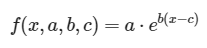

A continuacion se tiene un ejemplo de regresion exponencial
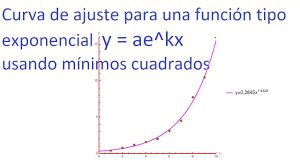

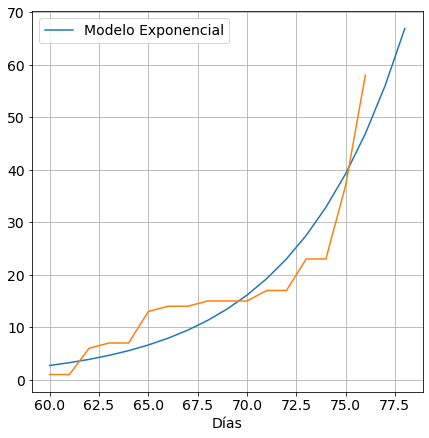

In [30]:
# Implementar
# Función para añadir días a la predicción
def devolverDias(adicion):
    dias = x.copy()
    for dia in range(77,(77+adicion)):
        dias.append(dia)
    return dias
        
# Definición de función exponencial
def genExp(varIn, a, b):
    return a*np.exp(b*varIn)

# Creación de dataframes para el almacenamieto de los resultados
modeloExp = pd.DataFrame(columns=('Días', 'Modelo Exponencial'))
modeloPol = pd.DataFrame(columns=('Días', 'Modelo Polinomial'))

parametros, valoresCovarianza = curve_fit(genExp, x, y, p0=(0,0))

# Adicion de días para prediccion
dias = devolverDias(2)

# Asignación de valores a la variable dependiente según la ecuación anterior
for pred in dias:
    modeloExp.loc[len(modeloExp)] = [pred,genExp(pred, parametros[0], parametros[1])]
# Gráfico del modelo exponencial
modeloExp.plot(x='Días', y='Modelo Exponencial')
plt.plot(df.loc[:,'date'],df.loc[:,'total_cases'])
plt.grid()

## Modelo polinomial
Predicción de una variable de respuesta cuantitativa a partir de una variable predictora cuantitativa, donde la relación se modela como una función polinomial de orden n (esto significa que pueden tener de diferentes exponenciales o grados y se debe ir probando)  

Se puede tener una ecuacion con diferentes grados

y = a0 + a1x + a2x^2 + a3x^3 + … + anx^n + ε

Ejemplo de una regresion polinomica de grado 4.
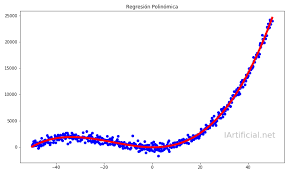


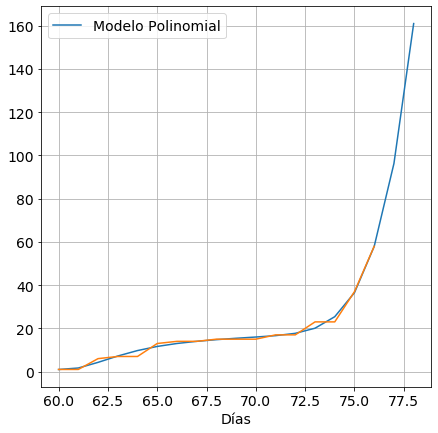

In [31]:
# Implementar 

# Se puede implementar modelos adicionales, en caso de ser asi explicar o dar una introduccion del modelo aplicado

# Se tomara como puntos adicionales al trabajo.
# Obtención de la ecuación polinomial de grado 'n'
y_polinomial = np.poly1d(np.polyfit(x,y,6))
# Asignación de valores a la variable dependiente según la ecuación anterior
for pred in dias:
    modeloPol.loc[len(modeloPol)] = [pred, y_polinomial(pred)]
# Gráfico del modelo polinomial de grado 9    
modeloPol.plot(x='Días',y='Modelo Polinomial')
plt.plot(df['date'], df['total_cases'])
plt.grid()

## Analisis
Gracias a la información que hoy en día nos facilita el gobierno y las organizaciones internacionales, y con la ayuda de herramientas de análisis matemático es posible predecir la cantidad de afectados por una crisi tal como es el covid-19, y mediante esto tomar decisiones y comprender la gravedad del asunto.
## Conclusiones
Es de vital importancia hacer uso de las herramientas de simulación que hoy en día se tienen a la mano, para predecir las repercusiones que una catástrofe puede presentar en una sociedad y de esta manera, proteger a los individuos que la conforman, no únicamente se puede usar en este caso, si no también en casos económicos como la predicción del alza de acciones de empresas para quienes buscan invertir.

## Criterio personal (politico, economico y  social de la situacion)
Una vez entendido el proceso que se debe atravesar para obtener una predicción basada en echos históricos, y superada la curva de aprendizaje, los beneficios que representa visualizar dicha predicción superan con creces el tiempo que tomo definir los algoritmos respectivos, lo cual queda reflejado en su uso para estudios e investigaciones.

# Referencias

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/